In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_validate, cross_val_predict
from pyearth import Earth
from pygam import LinearGAM, GAM, f, s, te

In [39]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [40]:
df = pd.read_csv('kc_house_data.csv', index_col=0)
df.head(2)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(2)
memory usage: 3.5+ MB


In [42]:
def peek(df):
    return df.head(3).append(df.tail(3))

In [43]:
peek(df)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287
1523300157,10/15/2014,325000.0,2,0.75,1020,1076,2.0,0.0,0.0,3,7,1020,0.0,2008,0.0,98144,47.5941,-122.299,1020,1357


In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,21597.0,540296.573506,367368.140101,78000.0000,322000.0000,450000.0000,645000.000,7.700000e+06
bedrooms,21597.0,3.373200,0.926299,1.0000,3.0000,3.0000,4.000,3.300000e+01
bathrooms,21597.0,2.115826,0.768984,0.5000,1.7500,2.2500,2.500,8.000000e+00
sqft_living,21597.0,2080.321850,918.106125,370.0000,1430.0000,1910.0000,2550.000,1.354000e+04
sqft_lot,21597.0,15099.408760,41412.636876,520.0000,5040.0000,7618.0000,10685.000,1.651359e+06
floors,21597.0,1.494096,0.539683,1.0000,1.0000,1.5000,2.000,3.500000e+00
waterfront,19221.0,0.007596,0.086825,0.0000,0.0000,0.0000,0.000,1.000000e+00
view,21534.0,0.233863,0.765686,0.0000,0.0000,0.0000,0.000,4.000000e+00
condition,21597.0,3.409825,0.650546,1.0000,3.0000,3.0000,4.000,5.000000e+00
grade,21597.0,7.657915,1.173200,3.0000,7.0000,7.0000,8.000,1.300000e+01


In [45]:
df.isnull().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [46]:
df_water = df[df['waterfront'].isna() == True]
df_water[df_water['yr_renovated'].isna() == True]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
8091400200,5/16/2014,252700.0,2,1.50,1070,9643,1.0,NaN,0.0,3,7,1070,0.0,1985,NaN,98030,47.3533,-122.166,1220,8386
5547700270,7/15/2014,625000.0,4,2.50,2570,5520,2.0,NaN,0.0,3,9,2570,0.0,2000,NaN,98074,47.6145,-122.027,2470,5669
1328310370,4/2/2015,375000.0,3,2.50,2340,10005,1.0,NaN,0.0,4,8,1460,880.0,1978,NaN,98058,47.4431,-122.133,2250,8162
3127200041,6/13/2014,589000.0,4,3.00,2440,9600,2.0,NaN,0.0,5,7,2440,0.0,1961,NaN,98034,47.7044,-122.200,2290,9600
2264500350,4/18/2015,615000.0,4,1.00,1330,2400,1.5,NaN,0.0,4,6,1330,0.0,1901,NaN,98103,47.6500,-122.340,1330,4400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937300430,9/29/2014,928990.0,4,2.50,3570,6054,2.0,NaN,0.0,3,9,3570,0.0,2014,NaN,98052,47.7053,-122.126,3600,6050
3448740360,4/29/2015,418500.0,4,2.50,2190,4866,2.0,NaN,0.0,3,7,2190,0.0,2009,NaN,98059,47.4907,-122.152,2190,5670
6891100090,10/14/2014,850000.0,5,3.50,4200,5400,2.0,NaN,0.0,3,9,3140,1060.0,2012,NaN,98052,47.7077,-122.120,3300,5564


In [47]:
df['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [48]:
idx = df['waterfront'] == 1
df['waterfront'].loc[idx] = 2

In [49]:
df['waterfront'].value_counts()

0.0    19075
2.0      146
Name: waterfront, dtype: int64

In [50]:
idx = df['waterfront'].isna() == True
df['waterfront'].loc[idx] = 1

In [51]:
df['waterfront'].value_counts()

0.0    19075
1.0     2376
2.0      146
Name: waterfront, dtype: int64

In [52]:
df['waterfront_null'] = df['waterfront'].apply(lambda x: 1 if x == 1 else 0)
df['waterfront_null'].value_counts()

0    19221
1     2376
Name: waterfront_null, dtype: int64

In [53]:
df['waterfront_ind'] = df['waterfront'].apply(lambda x: 1 if x == 2 else 0)
df['waterfront_ind'].value_counts()

0    21451
1      146
Name: waterfront_ind, dtype: int64

In [54]:
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [55]:
df['yr_renovated_scheme1'] = 0

idx = df['yr_renovated'] > 0
df['yr_renovated_scheme1'].loc[idx] = 2

idx = df['yr_renovated'].isna() == True
df['yr_renovated_scheme1'].loc[idx] = 1

df['yr_renovated_scheme1'].value_counts()

0    17011
1     3842
2      744
Name: yr_renovated_scheme1, dtype: int64

In [56]:
df['yr_renovated_null'] = df['yr_renovated_scheme1'].apply(lambda x: 1 if x == 1 else 0)
df['yr_renovated_null'].value_counts()

0    17755
1     3842
Name: yr_renovated_null, dtype: int64

In [57]:
df['yr_renovated_ind'] = df['yr_renovated_scheme1'].apply(lambda x: 1 if x == 2 else 0)
df['yr_renovated_ind'].value_counts()

0    20853
1      744
Name: yr_renovated_ind, dtype: int64

In [58]:
df.corr()['price'].abs().sort_values(ascending=False)

price                   1.000000
sqft_living             0.701917
grade                   0.667951
sqft_above              0.605368
sqft_living15           0.585241
bathrooms               0.525906
view                    0.395734
bedrooms                0.308787
lat                     0.306692
waterfront_ind          0.264306
floors                  0.256804
yr_renovated            0.129599
yr_renovated_ind        0.117543
waterfront              0.114792
sqft_lot                0.089876
yr_renovated_scheme1    0.083330
sqft_lot15              0.082845
yr_built                0.053953
zipcode                 0.053402
condition               0.036056
long                    0.022036
waterfront_null         0.010400
yr_renovated_null       0.002127
Name: price, dtype: float64

In [59]:
df.shape

(21597, 25)

In [60]:
df[df['long'] < -121.85]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_null,waterfront_ind,yr_renovated_scheme1,yr_renovated_null,yr_renovated_ind
id,,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,1.0,0.0,3,...,98178,47.5112,-122.257,1340,5650,1,0,0,0,0
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,98125,47.7210,-122.319,1690,7639,0,0,2,0,1
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,98028,47.7379,-122.233,2720,8062,0,0,1,1,0
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,98136,47.5208,-122.393,1360,5000,0,0,0,0,0
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,98074,47.6168,-122.045,1800,7503,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,...,98103,47.6993,-122.346,1530,1509,0,0,0,0,0
6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,...,98146,47.5107,-122.362,1830,7200,0,0,0,0,0
1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,...,98144,47.5944,-122.299,1020,2007,0,0,0,0,0


In [61]:
df = df[df['long'] < -121.85]
df.shape

(21297, 25)

In [62]:
df.isnull().sum()

date                       0
price                      0
bedrooms                   0
bathrooms                  0
sqft_living                0
sqft_lot                   0
floors                     0
waterfront                 0
view                      62
condition                  0
grade                      0
sqft_above                 0
sqft_basement              0
yr_built                   0
yr_renovated            3800
zipcode                    0
lat                        0
long                       0
sqft_living15              0
sqft_lot15                 0
waterfront_null            0
waterfront_ind             0
yr_renovated_scheme1       0
yr_renovated_null          0
yr_renovated_ind           0
dtype: int64

In [63]:
del df['yr_renovated']
df.isnull().sum()

date                     0
price                    0
bedrooms                 0
bathrooms                0
sqft_living              0
sqft_lot                 0
floors                   0
waterfront               0
view                    62
condition                0
grade                    0
sqft_above               0
sqft_basement            0
yr_built                 0
zipcode                  0
lat                      0
long                     0
sqft_living15            0
sqft_lot15               0
waterfront_null          0
waterfront_ind           0
yr_renovated_scheme1     0
yr_renovated_null        0
yr_renovated_ind         0
dtype: int64

In [64]:
df['view'].value_counts()

0.0    19150
2.0      938
3.0      501
1.0      330
4.0      316
Name: view, dtype: int64

In [65]:
df[df.view.isna() == True]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_null,waterfront_ind,yr_renovated_scheme1,yr_renovated_null,yr_renovated_ind
id,,,,,,,,,,,,,,,,,,,,,
2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,3,...,98198,47.4095,-122.315,1650,9711,0,0,0,0,0
8961960160,10/28/2014,480000.0,4,2.50,3230,16171,2.0,0.0,NaN,3,...,98001,47.3183,-122.253,2640,8517,0,0,0,0,0
3456000310,8/4/2014,840000.0,4,1.75,2480,11010,1.0,0.0,NaN,4,...,98040,47.5378,-122.219,2770,10744,0,0,1,1,0
1895000260,7/21/2014,207950.0,2,2.00,890,5000,1.0,0.0,NaN,3,...,98118,47.5158,-122.264,1860,5000,0,0,0,0,0
2525069041,9/4/2014,505000.0,3,1.50,1830,217800,1.0,0.0,NaN,3,...,98053,47.6277,-121.972,2450,165963,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148000475,5/28/2014,1400000.0,4,3.25,4700,9160,1.0,0.0,NaN,3,...,98116,47.5744,-122.406,2240,8700,0,0,0,0,0
291310170,8/4/2014,384500.0,3,2.50,1600,2610,2.0,0.0,NaN,3,...,98027,47.5344,-122.068,1445,1288,0,0,1,1,0
1196003740,9/24/2014,734000.0,5,4.25,4110,42755,2.0,0.0,NaN,3,...,98023,47.3375,-122.337,2730,12750,0,0,1,1,0


In [66]:
df[df.view.isna() == False]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_null,waterfront_ind,yr_renovated_scheme1,yr_renovated_null,yr_renovated_ind
id,,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,1.0,0.0,3,...,98178,47.5112,-122.257,1340,5650,1,0,0,0,0
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,98125,47.7210,-122.319,1690,7639,0,0,2,0,1
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,98028,47.7379,-122.233,2720,8062,0,0,1,1,0
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,98136,47.5208,-122.393,1360,5000,0,0,0,0,0
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,98074,47.6168,-122.045,1800,7503,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,...,98103,47.6993,-122.346,1530,1509,0,0,0,0,0
6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,...,98146,47.5107,-122.362,1830,7200,0,0,0,0,0
1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,...,98144,47.5944,-122.299,1020,2007,0,0,0,0,0


In [67]:
df = df[df.view.isna() == False]

In [68]:
df[df.bedrooms == 33]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_null,waterfront_ind,yr_renovated_scheme1,yr_renovated_null,yr_renovated_ind
id,,,,,,,,,,,,,,,,,,,,,
2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,5,...,98103,47.6878,-122.331,1330,4700,0,0,0,0,0


In [69]:
df = df[df.bedrooms != 33]

In [70]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'waterfront_null', 'waterfront_ind',
       'yr_renovated_scheme1', 'yr_renovated_null', 'yr_renovated_ind'],
      dtype='object')

In [79]:
df[df.sqft_basement == '?']

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_null,waterfront_ind,yr_renovated_scheme1,yr_renovated_null,yr_renovated_ind
id,,,,,,,,,,,,,,,,,,,,,
1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,...,98003,47.3097,-122.327,2238,6819,0,0,0,0,0
16000397,12/5/2014,189000.0,2,1.00,1200,9850,1.0,0.0,0.0,4,...,98002,47.3089,-122.210,1060,5095,0,0,0,0,0
7203220400,7/7/2014,861990.0,5,2.75,3595,5639,2.0,0.0,0.0,3,...,98053,47.6848,-122.016,3625,5639,0,0,0,0,0
1531000030,3/23/2015,720000.0,4,2.50,3450,39683,2.0,0.0,0.0,3,...,98010,47.3420,-122.025,3350,39750,0,0,0,0,0
2525310310,9/16/2014,272500.0,3,1.75,1540,12600,1.0,0.0,0.0,4,...,98038,47.3624,-122.031,1540,11656,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226049565,7/11/2014,504600.0,5,3.00,2360,5000,1.0,0.0,0.0,3,...,98103,47.6931,-122.330,2180,5009,0,0,0,0,0
1760650900,7/21/2014,337500.0,4,2.50,2330,4907,2.0,0.0,0.0,3,...,98042,47.3590,-122.081,2300,3836,0,0,1,1,0
6021503707,1/20/2015,352500.0,2,2.50,980,1010,3.0,1.0,0.0,3,...,98117,47.6844,-122.387,980,1023,1,0,0,0,0


In [81]:
idx = df['sqft_basement'] == '?'
df['sqft_basement'].loc[idx] = df['sqft_living'].loc[idx] - df['sqft_above'].loc[idx]

In [82]:
df[df['sqft_basement'] == '?']

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_null,waterfront_ind,yr_renovated_scheme1,yr_renovated_null,yr_renovated_ind
id,,,,,,,,,,,,,,,,,,,,,


In [83]:
np.sum(df['sqft_basement'].loc[idx] < 0)

0

In [85]:
df.sqft_basement.astype(float).astype(int)

id
7129300520      0
6414100192    400
5631500400      0
2487200875    910
1954400510      0
             ... 
263000018       0
6600060120      0
1523300141      0
291310100       0
1523300157      0
Name: sqft_basement, Length: 21234, dtype: int64

In [86]:
df.sqft_basement = df.sqft_basement.astype(float).astype(int)

In [87]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'waterfront_null', 'waterfront_ind',
       'yr_renovated_scheme1', 'yr_renovated_null', 'yr_renovated_ind'],
      dtype='object')

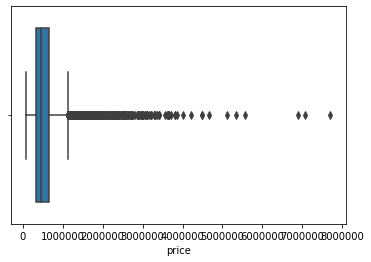

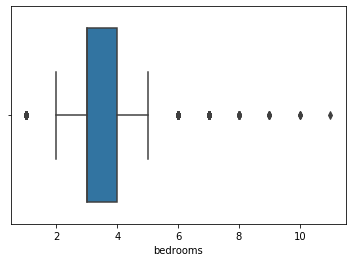

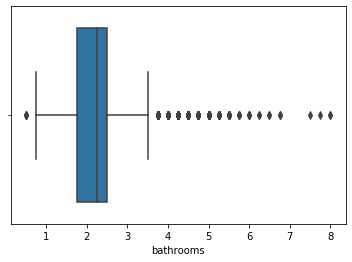

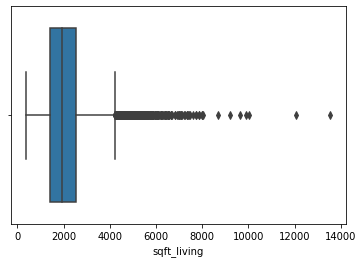

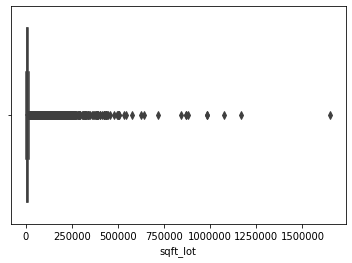

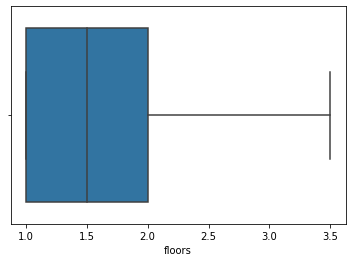

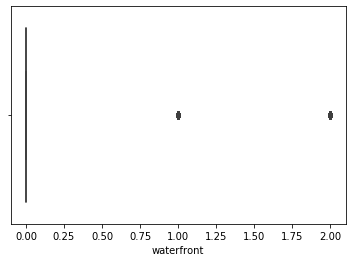

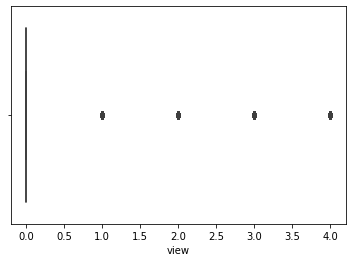

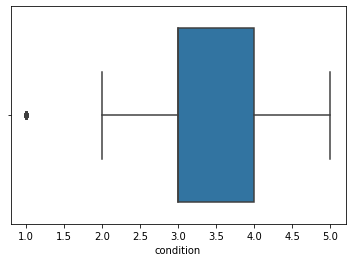

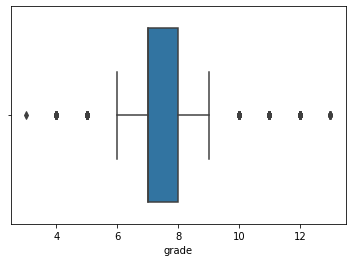

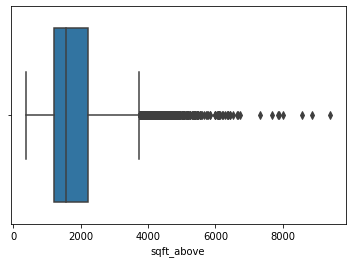

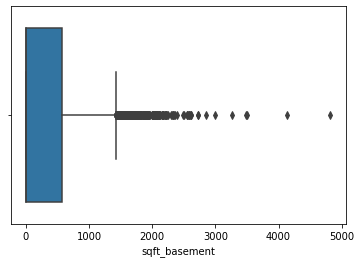

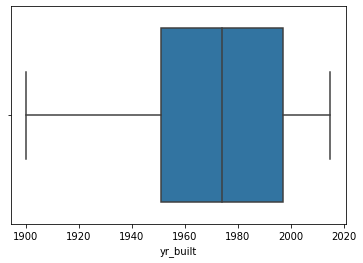

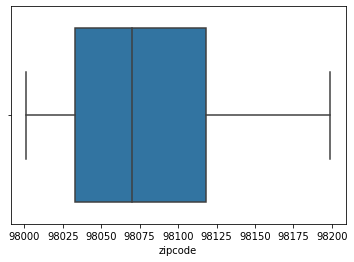

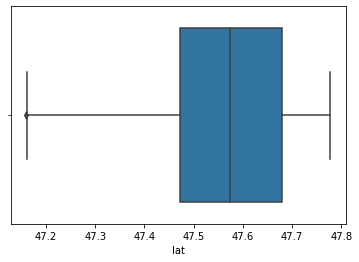

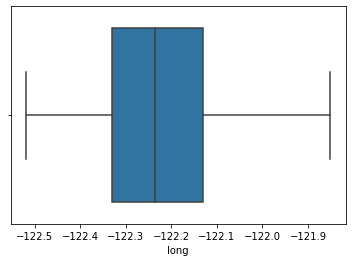

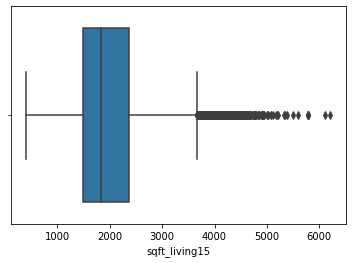

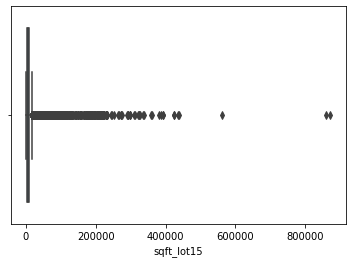

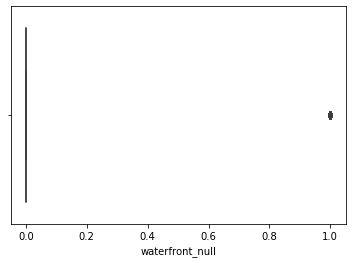

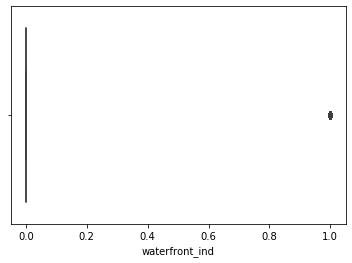

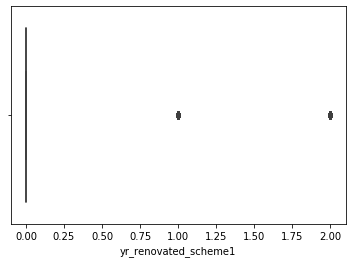

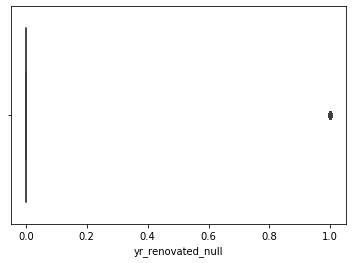

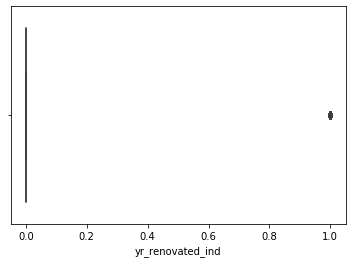

In [88]:
boxplot_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'waterfront_null', 'waterfront_ind',
       'yr_renovated_scheme1', 'yr_renovated_null', 'yr_renovated_ind']

# left out sqft_basement
def print_boxplot(df):
   for c in df[boxplot_cols]:
       sns.boxplot(df[c])
       plt.show()
    
print_boxplot(df)

In [89]:
ls

ColumnNames.md              clean_data.ipynb
Mod2-Project_HTX-DS-111819/ kc_house_data.csv
README.md                   kc_housing.ipynb
Untitled.ipynb              king_county_edna.ipynb


In [90]:
df.to_csv('kc_house_data_clean.csv')

In [91]:
ls

ColumnNames.md              kc_house_data.csv
Mod2-Project_HTX-DS-111819/ kc_house_data_clean.csv
README.md                   kc_housing.ipynb
Untitled.ipynb              king_county_edna.ipynb
clean_data.ipynb


In [92]:
df.shape

(21234, 24)